In [49]:
import numpy as np
from datasets import load_from_disk
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
import os
os.environ["HF_DATASETS_CACHE"]="/job_workspace/.cache/huggingface/dataset"

In [ ]:
#datasets = load_from_disk('/job_workspace/how2_all_proc_10p') #Just filtered Velocity

In [ ]:
datasets

In [ ]:
from utils.dataset import setup_data
datasets = setup_data('/job_workspace/how2_all_proc_10p', ds_frac=0.1)

In [62]:
epoch = 50
output_dirs={
    'z90':'training_output_05_15_30_01_2024',
    'm90':'training_output_01_09_30_01_2024',
    'm90-2': 'training_output_05_40_30_01_2024_1',
    'z50':'training_output_05_26_30_01_2024',
    'm50':'training_output_05_34_30_01_2024',
    'm50-2': 'training_output_07_10_30_01_2024',
    'z30':'training_output_16_13_30_01_2024',
    'm30': 'training_output_16_04_30_01_2024',
    'z10':'training_output_16_22_30_01_2024_2',
    'm10':'training_output_16_19_30_01_2024'
}
embeddings={
    'z90':'training_output_04_15_31_01_2024',
    'm90':'training_output_03_41_31_01_2024',
    'm90-2': 'training_output_06_21_31_01_2024',
    'z50':'training_output_04_47_31_01_2024',
    'm50':'training_output_05_54_31_01_2024',
    'm50-2': 'training_output_07_27_31_01_2024',
    'z30':'training_output_09_09_31_01_2024',
    'm30': 'training_output_08_01_31_01_2024',
    'z10':'training_output_10_44_31_01_2024',
    'm10':'training_output_09_35_31_01_2024'
}

In [106]:
#TBD
from torch import nn
def compute_cosines(embedding, embeddings):
    #for k,v in embeddings.items():
    cos0 = torch.nn.CosineSimilarity(dim=1)
    return cos0(embedding.unsqueeze(0).repeat(embeddings.shape[0],1), embeddings)
def get_rank(x, indices):
    vals = x[range(len(x)), indices]
    return (x > vals[:, None]).long().sum(1)

In [115]:
import torch
test = 'm10'
e=torch.load(f'../{embeddings[test]}/train_embeddings.pt')
m=torch.load(f'../{embeddings[test]}/train_masks.pt')

In [121]:
e

{'aud': tensor([[-0.7407, -0.8214, -0.4318,  ..., -1.0077,  0.9413, -1.4480],
         [-0.7016, -0.3371, -0.3752,  ..., -0.5077, -0.1076, -0.5319],
         [-0.6587, -0.3019, -0.4670,  ..., -0.5233, -0.0919, -0.4304],
         ...,
         [-0.6528, -0.3527, -0.4611,  ..., -0.5155, -0.0841, -0.4382],
         [-0.6372, -0.3683, -0.3007,  ..., -0.4999, -0.0763, -0.5476],
         [-0.6684, -0.3683, -0.4484,  ..., -0.4999, -0.0763, -0.4226]],
        device='cuda:0'),
 'en': tensor([[-0.6710, -0.3280, -0.4445,  ..., -0.5199, -0.0620, -0.4638],
         [-0.6207, -0.2557, -0.3488,  ..., -0.5433, -0.1479, -0.5029],
         [-0.7042, -0.3085, -0.4396,  ..., -0.5902, -0.0933, -0.4560],
         ...,
         [-0.6749, -0.3104, -0.4230,  ..., -0.5199, -0.1167, -0.4169],
         [-0.6466, -0.2811, -0.3859,  ..., -0.5121, -0.1714, -0.4873],
         [-0.6925, -0.3456, -0.4777,  ..., -0.4808, -0.0854, -0.4326]],
        device='cuda:0'),
 'pt': tensor([[-0.6999,  0.2031, -0.8655,  ...,  0.6

In [127]:
def rank_metrics(embeddings, masks, modality, fusion="fusion"):
    c=list()
    xc=list()
    idx = list()
    batch_size = 4096*2
    for i in range(batch_size):
        mx=m[modality][i]
        if not mx:
            pass
        idx.append(i)
        x=e[modality][i,:] #.shape
        #xx=e['pt']
        #xc.append(compute_recall(x,xx).topk(10))
        y=e[fusion]#.shape
        c.append(compute_recall(x,y))
        #print(c[i].topk(25))
        #_=plt.hist(c.cpu(), bins=1000, log=True)
    ranks = get_rank(torch.stack(c), torch.tensor(idx))
    median_rank = ranks.median()
    r1 = sum(ranks == 0)/len(ranks)
    r5 = sum(ranks < 5)/len(ranks)
    r10 = sum(ranks < 10)/len(ranks)
    return median_rank, r1, r5, r10

In [129]:
modalities = ['aud','en','pt','sm']
for k,v in embeddings.items():
    e=torch.load(f'../{v}/train_embeddings.pt')
    m=torch.load(f'../{v}/train_masks.pt')
    for k2 in modalities:
        print(f"{k}-{k2}-{[x.cpu().value for x in median_rank(e,m,k2)]")

KeyboardInterrupt: 

In [133]:
modalities = ['aud','en','pt','sm']
for k,v in embeddings.items():
    e=torch.load(f'../{v}/eval_embeddings.pt')
    m=torch.load(f'../{v}/eval_masks.pt')
    for k2 in modalities:
        print(f"{k}-{k2}-{[x.cpu().item() for x in median_rank(e,m,k2)]}")

z90-aud-[379, 0.0550537109375, 0.0723876953125, 0.074951171875]
z90-en-[16, 0.0089111328125, 0.0247802734375, 0.03662109375]
z90-pt-[15, 0.0096435546875, 0.027099609375, 0.0394287109375]
z90-sm-[2465, 0.00390625, 0.016845703125, 0.03076171875]
m90-aud-[0, 0.7554931640625, 0.7591552734375, 0.759521484375]
m90-en-[4940, 0.079345703125, 0.0897216796875, 0.092041015625]
m90-pt-[5596, 0.081298828125, 0.0921630859375, 0.095703125]
m90-sm-[5886, 0.0650634765625, 0.0721435546875, 0.075927734375]
m90-2-aud-[2203, 0.0701904296875, 0.07763671875, 0.07861328125]
m90-2-en-[3266, 0.0723876953125, 0.083740234375, 0.087646484375]
m90-2-pt-[2340, 0.0777587890625, 0.0889892578125, 0.0919189453125]
m90-2-sm-[3920, 0.0645751953125, 0.0718994140625, 0.0760498046875]
z50-aud-[4536, 0.0662841796875, 0.127685546875, 0.1556396484375]
z50-en-[2264, 0.0009765625, 0.004638671875, 0.0078125]
z50-pt-[2228, 0.0008544921875, 0.0054931640625, 0.0087890625]
z50-sm-[4044, 0.0003662109375, 0.004150390625, 0.0081787109375

tensor(1032.)


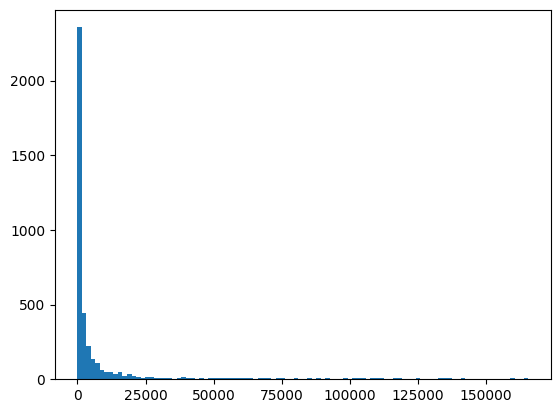

In [118]:
print(ranks.float().cpu().median())
_ = plt.hist(ranks.cpu(), bins=100)

In [36]:
cos0 = torch.nn.CosineSimilarity(dim=1)
output0 = cos0(torch.ones([3,10]), torch.ones([3,10]))
output0

tensor([1.0000, 1.0000, 1.0000])

In [ ]:
!ls ../training_output_03_41_31_01_2024/

In [ ]:
from safetensors.torch import load_model
from model import MFDOOM
from encoders import MultimodalCollator
from torch.utils.data import DataLoader
from utils.config import training_config, get_model_config
output_dir = "/efs-private/multimodal/training_output_01_35_20_01_2024" #0.8 Doom
#output_dir = "/efs-private/multimodal/training_output_01_36_20_01_2024" #0.3 Doom
#output_dir = "/efs-private/multimodal/training_output_01_38_20_01_2024" #0.8 Zorro
#output_dir = "/efs-private/multimodal/training_output_01_37_20_01_2024" #0.3 Zorro
config = training_config(os.path.join(output_dir,'config.yaml'))
model_config = get_model_config(config)
model_config['batch_size']=4

In [ ]:
import model
from importlib import reload
reload(model)
from model import MFDOOM

In [ ]:
default_data_collator = MultimodalCollator(config.modality_config)
#dataloader2 = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
dataloader = DataLoader(datasets['test'].with_format('torch'), 
                        shuffle=True, 
                        collate_fn=default_data_collator, 
                        batch_size=4,)

In [ ]:
import torch
model = MFDOOM(**model_config)

In [ ]:
import torch
from safetensors.torch import load_model
load_model(model,os.path.join(output_dir,'model.safetensors'))

In [ ]:
dl=iter(dataloader)
infer_model = model.eval()
#batch = [next(dl) for x in range(4)]
output = [infer_model(next(dl)) for _ in range(2)]

In [ ]:
def zero_modes(batch, modes_to_zero):
    for mode in modes_to_zero:
        print(mode)
        if mode == 'aud':
            batch[mode]['values'] = torch.ones_like(batch[mode]['values'])*-10000
        elif mode == 'vid':
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
        else:
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
    return batch

In [ ]:
from tqdm import tqdm
from collections import defaultdict
import copy
import random
output=defaultdict(list)
infer_model = model.eval()
dl = iter(dataloader)
#mode_sets = [('aud',),('sm',),('en',),('pt',),('vid',)]
mode_sets = [('aud','sm',), ('vid','aud',), ('sm','en','pt',)]
batches = []
with torch.no_grad():
    for i in tqdm(range(4)):
        batch = next(dl)
        batches.append(batch)
        #batch = {k: {k2: v2 for k2,v2 in v.items()} for k,v in batch.items()}
        output[('baseline',)].append(infer_model(batch))
        random.shuffle(mode_sets)
        for modes in mode_sets:
            mode_batch = copy.deepcopy(batch)
            output[modes].append(infer_model(zero_modes(mode_batch,modes)))
print(output)

In [ ]:
def refactor(outputs):
    out_dict = {k:[] for k in outputs[0]}
    for k in ["losses", "loss", "modality_sample_mask"]:
        out_dict.pop(k, None)
    for batch in outputs:
        for key in out_dict.keys():
            out_dict[key].append(batch[key])
    print(out_dict.keys())
    out_dict = {k:torch.cat(v) for k,v in out_dict.items()}
    return out_dict

In [ ]:
output_r = {k: refactor(v) for k,v in output.items()}

In [ ]:
output[('baseline',)][0]['aud']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cosines(output, output2=None, log=False, vmin=None, vmax=None, plot_diag=True):
    cos = torch.nn.CosineSimilarity(dim=0)
    mat_dict={}
    for k,v in output.items():
        l = v.shape[0]
        mat_dict[k]=np.zeros([l,l])
        v2 = output2[k] if output2 else output['fusion']
        for i in range(l):
            for j in range(l):
                #print(f"{i},{j},{cos(output.fusion[i],output.fusion[j])}")
                if log:
                    mat_dict[k][i,j]=np.log10(cos(v[i],v2[j]))
                else:
                    mat_dict[k][i,j]=cos(v[i],v2[j])

    f, ax = plt.subplots(len(mat_dict),2, figsize=(6,3*len(mat_dict)))
    for i,(k,mat) in enumerate(mat_dict.items()):
        #f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
        #plt.figure(figsize=(2,2))
        #ax1.title(k)
        ax1 = ax[i,0]
        im = ax1.imshow(mat, vmin=vmin, vmax=vmax)
        ax1.set_ylabel(k)
        f.colorbar(im,ax=ax1)
        if plot_diag:
            #plt.figure(figsize=(2,2))
            #plt.title(f"{k} diagonals")
            bins = np.linspace(0,1.0,100)
            ax2 = ax[i,1]
            ax2.hist(np.diagonal(mat), bins=bins, alpha=0.3,density=True)
            ax2.hist(mat.flatten(), bins=bins, alpha=0.3, density=True)
            ax2.set_ylim(0,50)
            ax2.set_xlim(0,1.0)
            ax2.annotate(str(np.mean((mat.sum(1)-np.diag(mat))/(mat.shape[1]-1))),
                        [0.1, 0.1])
            ax2.legend(["diag","all"])

        

In [ ]:
print(output_r.keys())

In [ ]:
k = mode_sets[0]
print(k)
plot_cosines(output_r[('baseline',)],output_r[k],vmin=0.99999) #

# Attention masking tests

In [ ]:
plt.imshow(model.pool_mask, aspect=100)
plt.colorbar()

In [ ]:
t=torch.load('../batch.pt', map_location=torch.device('cpu'))
p=torch.load('../padding_mask.pt', map_location=torch.device('cpu'))
a = torch.load('../attn_mask.pt', map_location=torch.device('cpu'))

In [ ]:
plt.plot(p[0,:])
plt.figure()
plt.plot(p[1,:])
plt.figure()
plt.plot(p[4,:])

In [ ]:
plt.imshow(a)

In [ ]:
print(t.isnan().reshape((-1,t.shape[1]*t.shape[2]))
      .shape)
plt.imshow(torch.cat([t.isnan()[i,:,:] for i in range(8)], dim=1))
plt.colorbar()

In [ ]:
plt.imshow(model.attn_mask)

In [ ]:
import torch
token_types = torch.tensor(list((
    *((0,) * 1024),
    *((1,) * 1024),
    *((2,) * 1024),
    *((3,) * 1024),
)), dtype=torch.long)

In [ ]:
token_types.shape

In [ ]:
from einops import rearrange, repeat

In [ ]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [ ]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [ ]:
zorro_mask = zorro_mask | (token_types_attend_from == 3)

In [ ]:
token_types
floom_mask = [token_types != i for i in range(-1,3)]
for idx, tokens in enumerate(floom_mask):
    print(idx)
    a = -256*4 + 256*idx
    b = -256*4 + 256*(idx+1)-1
    print(f"{a}:{b}")
    tokens[-256*4:] = False
    tokens[a:b]= True
floom_mask = repeat(floom_mask, 'i j -> (i i2) j', i2=256)
plt.imshow(floom_mask)#, aspect = 1000)

In [ ]:
import matplotlib.pyplot as plt
zorro_mask[token_types == 3] = floom_mask
plt.imshow(zorro_mask)

In [ ]:
ax = plt.subplot(1,1,1)
im = ax.imshow(attn_mask[3,:,:] * zorro_mask)
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
torch.empty(0)

In [ ]:
batch

In [ ]:
return_token_types = (0,1,2,3,3,3,3,4)
return_token_types_tensor = torch.tensor(list(return_token_types))
max_return_tokens = len(return_token_types)
dim=512
return_tokens = torch.nn.Parameter(torch.randn(max_return_tokens, dim))
return_tokens = repeat(return_tokens, 'n d -> b n d', b=4)

In [ ]:
return_tokens.shape

In [ ]:
pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
            token_types_attend_to, dtype=torch.long) * 4)

In [ ]:
plt.imshow(pool_mask.to(torch.long), aspect=1000) #'auto')
plt.colorbar()

In [ ]:
floom_pool_mask = torch.block_diag(torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)))
print(token_types.shape)
select_mask = (return_token_types_tensor == 3).unsqueeze(1) *(token_types == 3).unsqueeze(0)
print(select_mask.shape)
pool_mask[select_mask] = floom_pool_mask.to(torch.bool).flatten()
#floom_mask = repeat(floom_mask, 'i j -> i j')
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask, aspect=1000, interpolation='none')

In [ ]:
plt.imshow((return_token_types_tensor == 3).unsqueeze(1) *
           (token_types == 3).unsqueeze(0), aspect =1000)

In [ ]:
plt.plot(pool_mask.T)

In [ ]:
padding_mask = repeat(padding, 'b j -> b i j', i=pool_mask.shape[0])
print(padding_mask.shape)
plt.imshow(padding_mask[0,:,:].squeeze(), aspect=1000)
plt.colorbar()

In [ ]:
pool_mask = pool_mask * padding_mask
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask[0], aspect=1000, interpolation='none')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
q=torch.tensor([[1,2],
                [1,1]])
k=torch.tensor([[1,1],
                [2,1]])
v=q

In [ ]:
from torch import einsum
sim = einsum('i d, d j -> i j', q, k) #Standard mm multipy
sim = einsum('i d, j d -> i j', q, k) #mm multiply with k transpose
print(sim)
#sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)
#attn = sim.softmax(dim=-1)
attn = sim
out = einsum('i j, j d -> i d', attn, v) #standard multiply with no tranpose
print(out)
### SO COLUMNS SHOULD BE -inf for the mask!

In [ ]:
sim

# Combine datasets

In [ ]:
from datasets import concatenate_datasets, load_from_disk
import os
os.environ['HF_DATASETS_CACHE']='/shared/.cache/hugginface/dataset'
datasets = [
   'ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all',
    'fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all',
    'cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all',
    'fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all'
]
root = '/shared/'
loaded_datasets=[]
for dataset in datasets:
    loaded_datasets.append(load_from_disk(os.path.join(root,dataset)))
all_datasets=concatenate_datasets(loaded_datasets)

In [ ]:
shuffled_dataset = all_datasets.shuffle(seed=42)

In [ ]:
len(shuffled_dataset)

In [ ]:
shuffled_dataset.save_to_disk(os.path.join(root,'dataset3M'))

In [ ]:
import torch

In [ ]:
t = torch.zeros(10)

In [ ]:
t[torch.tensor([0,4,9])]=torch.tensor([1,2,3], dtype=torch.float)

In [ ]:
t

In [ ]:
    f, ax= plt.subplots(4,2, figsize=(6,2))


In [ ]:
ax

In [ ]:
import datasets
!ls /shared
dataset = datasets.load_from_disk('/shared/how2_all_proc')

In [ ]:
dataset[0]['vid']

In [ ]:
    #if plot_diag:
        """
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        plt.hist(diags.values(), bins=20)
        plt.legend(diags.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('Diag Cosine Similarity')
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')        
        """
        #plt.figure()
        #plt.title("")

In [ ]:
x = torch.Tensor([[0,1,1,1],[0,1,1,0]])

In [ ]:
torch.randperm(10)[:3]

In [ ]:
x.swapaxes(0,1)

In [ ]:
x = [torch.Tensor([0.3]), torch.Tensor([1.3]), torch.Tensor([2.3]), torch.Tensor([np.nan])]

In [ ]:
y = torch.cat(x)

In [ ]:
z=~y.isnan()

In [ ]:
w=torch.sum(z)

In [ ]:
torch.sum(y[z])/w

In [ ]:
z